In [15]:
import pandas as pd
import numpy as np
import os
import folium
from folium import plugins
import webbrowser
# import osmnx
# import geopandas as gp
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import *

In [16]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [6]:
sp_data = pd.read_csv('singapore_listings.csv')
print(sp_data.shape)
sp_data.head()

(7907, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,9,353
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,9,355


mean of price: 169.33299607942328
over average price percentage: 30.9%
lower average price percentage: 69.1%


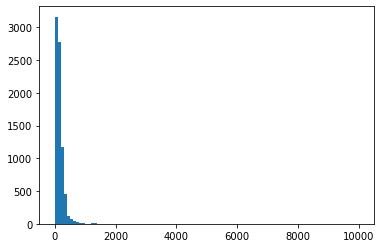

In [9]:
price = sp_data['price'].values
mean_price = np.mean(price)
print(f'mean of price: {mean_price}')
over_price = sum(sp_data['price'].values>mean_price)/len(price)
lower_price = sum(sp_data['price'].values<=mean_price)/len(price)
print(f'over average price percentage: {round(over_price*100,2)}%')
print(f'lower average price percentage: {round(lower_price*100,2)}%')
a,b,c = plt.hist(price,bins=100)

## Feature Analysis

In [31]:
lat = sp_data['latitude'].values
lon = sp_data['longitude'].values
min_nights = sp_data['minimum_nights'].values
num_reviews = sp_data['number_of_reviews'].values
ave_reviews = sp_data['reviews_per_month'].values
host_own = sp_data['calculated_host_listings_count'].values
avail = sp_data['availability_365'].values

In [32]:
pos_price = sp_data.groupby(['latitude','longitude']).price.unique().agg(dict)

In [91]:
def segment_position(pos_price, lat_bins, lon_bins):
    keys, values = [], []
    lat, lon = sorted([x[0] for x in pos_price.keys()]), sorted([x[1] for x in pos_price.keys()])
    batch_lat, batch_lon = len(pos_price)//lat_bins, len(pos_price)//lon_bins
    for i in tqdm_notebook(range(lat_bins)):
        lat_gap = lat[i*batch_lat: (i+1)*batch_lat]
        ave_lat = np.mean(lat_gap)
        for j in range(lon_bins):
            lon_gap = lon[j*batch_lon: (j+1)*batch_lon]
            ave_lon = np.mean(lon_gap)
            ave_values = []
            for m in range(batch_lat):
                for n in range(batch_lon):
                    if (lat_gap[m], lon_gap[n]) in pos_price.keys():
                        price_list = pos_price[(lat_gap[m], lon_gap[n])]
                        if len(price_list) == 1:
                            price = int(price_list)
                        else:
                            price = int(np.mean(price))
                        #print(price)
                        ave_values.append(price)
            if ave_values != []:
                val_ = np.mean(ave_values)
                values.append(val_)
                keys.append((ave_lat, ave_lon))
    return keys, values
        

In [80]:
keys, values = segment_position(pos_price, 100, 100)

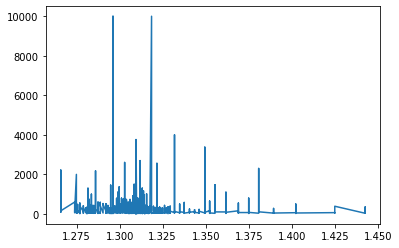

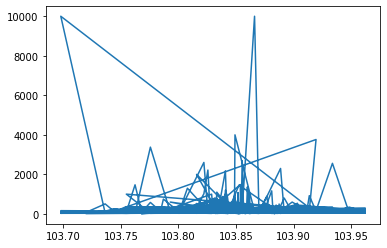

In [89]:
ave_lat, ave_lon = [x[0] for x in keys], [x[1] for x in keys]
vals = values.copy()
plt.plot(ave_lat, vals, label="latitude price distribution")
plt.show()
plt.plot(ave_lon, vals, label="longitude price distribution")
plt.show()
#plt.ylim(0,1)
#plt.ylabel ('Percentage')
#plt.xlabel ('Significant number')
#plt.xticks(list(keys))
#plt.legend (bbox_to_anchor=(1, 1), loc="upper right", borderaxespad=0.)


In [5]:
sp_map = folium.Map(location=[sp_data['latitude'].mean(), sp_data['longitude'].mean()], zoom_start = 10)
marker_cluster = plugins.MarkerCluster().add_to(sp_map)
for i in range(len(lat)):
     folium.Marker([lat[i], lon[i]], popup='<i>Mt. Hood Meadows</i>').add_to(marker_cluster)     
# sp_map.save("sp_map.html")
# webbrowser.open("sp_map.html")

In [6]:
price = sp_data['price'].values
nbh_group = sp_data['neighbourhood_group'].values
nbh = sp_data['neighbourhood'].values

(array([1105., 1643., 1042.,  692., 1899.,  831.,  232.,  321.,  130.,
          12.]),
 array([ 0. ,  4.2,  8.4, 12.6, 16.8, 21. , 25.2, 29.4, 33.6, 37.8, 42. ]),
 <a list of 10 Patch objects>)

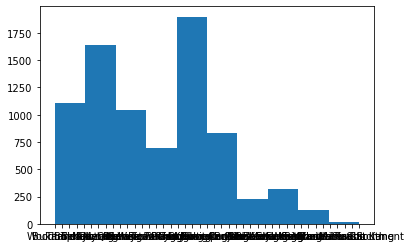

In [8]:
plt.hist(nbh)

In [9]:
hist = Counter(nbh_group)
hh = np.array(hist.values()).reshape(-1,1)

In [13]:
import fiona

<BarContainer object of 5 artists>

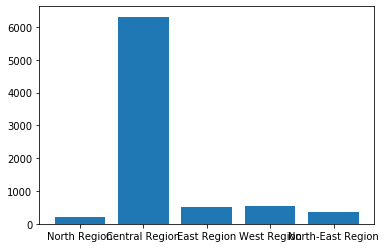

In [14]:
mm = list(hist.values())
plt.bar(list(hist.keys()),list(hist.values()))